In [285]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import re
import os
from typing import Any, Dict

import trimesh
import h5py

In [254]:

def load_mat(filename, exclude_pattern=".*#.*"):
    """
    Attempt to load the given MATLAB file as either an old-style file or as an HDF5 file. The keys in the
    HDF5 file which match `exclude_pattern` will be ignored. This currently does not resolve references
    in the HDF5 file.
    """
    try:
        return sio.loadmat(filename) # try to load old-style
    except NotImplementedError:
        # ignore the exception which should only indicate the file is HDF5
        pass
    
    # if we got here that means the NotImplementedError was raised, try h5py
    with h5py.File(filename, "r") as f:
        dat={}

        def _visitor(key, value):
            if isinstance(value, h5py.Dataset) and re.search(exclude_pattern, key) is None:
                arr_val = np.array(value)

                # ignore references for now
                if arr_val.dtype!=object:
                    dat[key] = arr_val

        f.visititems(_visitor)  # visit all items in the file and populate dat
                    
    return dat


dat = load_mat("new_dataset_2.mat")

for k,v in dat.items():
    print(k,v.dtype,v.shape)

userdata/cartoFolder uint64 (2,)
userdata/electric/annotations/mapAnnot float64 (1, 800)
userdata/electric/annotations/referenceAnnot float64 (1, 800)
userdata/electric/annotations/woi float64 (2, 800)
userdata/electric/barDirection float64 (3, 800)
userdata/electric/ecg float64 (2500, 800)
userdata/electric/egm float64 (2500, 800)
userdata/electric/egmRef float64 (2500, 800)
userdata/electric/egmSurfX float64 (3, 800)
userdata/electric/egmUni float64 (2, 2500, 800)
userdata/electric/egmUniX float64 (2, 3, 800)
userdata/electric/egmX float64 (3, 800)
userdata/electric/voltages/bipolar float64 (1, 800)
userdata/electric/voltages/unipolar float64 (1, 800)
userdata/rf/originaldata/ablparams/distaltemp float64 (1, 29762)
userdata/rf/originaldata/ablparams/impedance float64 (1, 29762)
userdata/rf/originaldata/ablparams/power float64 (1, 29762)
userdata/rf/originaldata/ablparams/time float64 (1, 29762)
userdata/rf/originaldata/force/axialangle float64 (1, 59083)
userdata/rf/originaldata/forc

In [319]:
class Case:
    def __init__(
        self,
        name: str,
        nodes: np.array,
        indices: np.array,
        fields: Dict[str, np.array],
        electric: Dict[str, np.array],
        rf: Dict[str, np.array],
        other_data: Dict[str, Any] = {},
    ):
        self.name: str = name
        self.nodes: np.array = nodes
        self.indices: np.array = indices
        self.fields: Dict[str, np.array] = dict(fields)
        self.electric: Dict[str, np.array] = dict(electric)
        self.rf: Dict[str, np.array] = dict(electric)
        self.other_data: Dict[str, Any] = dict(other_data)

    def __repr__(self):
        return f"{self.name}( nodes: {self.nodes.shape} indices: {self.indices.shape} fields: {tuple(self.fields)} )"

    def create_mesh(self, vertex_norms=True, recenter=True):
        inds_inverted = self.indices[:, [0, 2, 1]]
        inds = np.vstack([self.indices, inds_inverted])  # include each triangle twice for both surfaces

        mesh = trimesh.Trimesh(self.nodes, inds, process=False)
        mesh._kwargs["parent"]=self

        if vertex_norms:
            mesh.vertex_normals  # compute vertex normals

        if recenter:
            mesh.apply_translation(-mesh.centroid)  # recenter mesh to origin, helps with lighting in default scene

        return mesh


def load_case(filename, name=None, exclude_pattern=".*#.*"):
    """
    Load a Case object from the given file. This assumes a number of names for objects found in the file. 
    """
    dat = load_mat(filename, exclude_pattern)

    if name is None:
        name = os.path.basename(filename)

    nodes = dat["userdata/surface/triRep/X"].T
    inds = dat["userdata/surface/triRep/Triangulation"].T - 1
    act, bip = dat["userdata/surface/act_bip"]
    uni, imp, frc = dat["userdata/surface/uni_imp_frc"]

    fields = dict(act=act, bip=bip, uni=uni, imp=imp, frc=frc)
    electric = {}
    rf = {}
    other_data = {}

    for k, v in dat.items():
        _, section, *objname = k.split("/", 2)

        if objname and section in ("electric", "rf"):
            dobj = rf if section == "rf" else electric
            dobj[objname[0]] = v
        else:
            other_data[k] = v

    return Case(name, nodes, inds, fields, electric, rf, other_data)


case = load_case("new_dataset_1.mat")
print(case, tuple(case.rf))

new_dataset_1.mat( nodes: (9279, 3) indices: (10296, 3) fields: ('act', 'bip', 'uni', 'imp', 'frc') ) ('annotations/mapAnnot', 'annotations/referenceAnnot', 'annotations/woi', 'barDirection', 'ecg', 'egm', 'egmRef', 'egmSurfX', 'egmUni', 'egmUniX', 'egmX', 'voltages/bipolar', 'voltages/unipolar')


In [320]:
case.create_mesh().show()

In [326]:
from matplotlib.cm import jet, rainbow, jet_r, seismic


def compute_field(
    mesh,
    fieldname,
    minval=0,
    maxval=1,
    color_map=jet_r,
    below_color=(0, 0, 0, 255),
    above_color=(255, 0, 255, 255),
    nan_color=(50, 50, 50, 255),
):
    case = mesh._kwargs["parent"]
    field = case.fields[fieldname]
    new_field = np.zeros((field.shape[0], 4), np.int32)

    for idx in range(len(field)):
        val = field[idx]

        if np.isnan(val):
            col = nan_color
        elif val < minval:
            col = below_color
        elif val > maxval:
            col = above_color
        else:
            valscaled = (val - minval) / (maxval - minval)
            col = color_map(valscaled)
            
            if isinstance(col[0],float):
                col=[int(c*255) for c in col]

        new_field[idx] = col

    mesh.visual.vertex_colors[:] = new_field

    return new_field

In [327]:
mesh=case.create_mesh()
compute_field(mesh,"bip",0,2,seismic)
mesh.show()

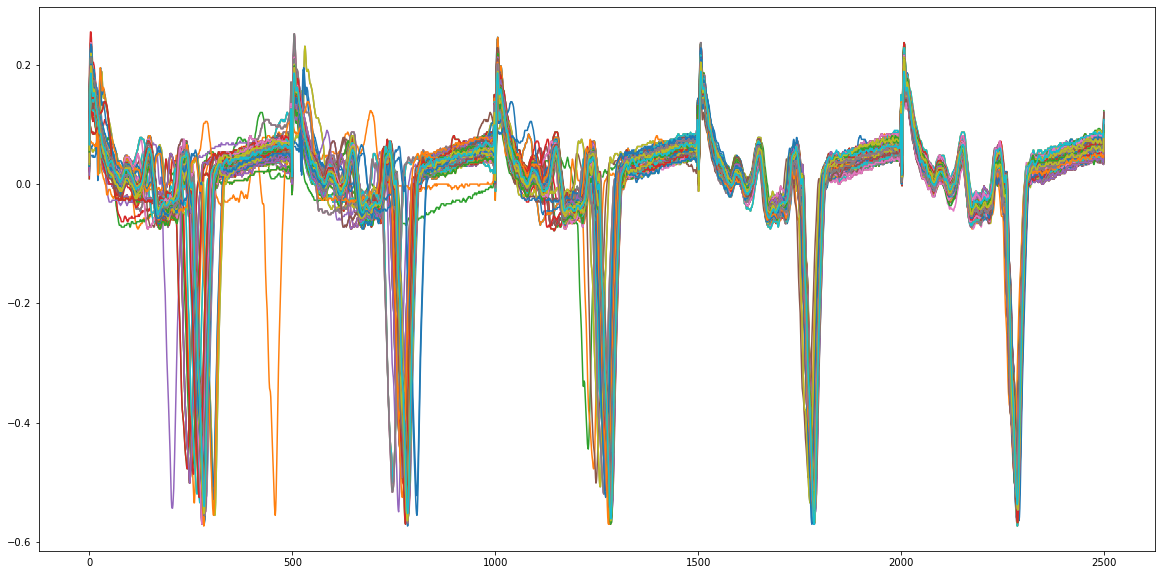

In [286]:
ecg=case.electric["ecg"]

plt.figure(figsize=(20,10))
_=plt.plot(ecg)

In [205]:
def rescale(arr):
    arr=arr.copy()
    arr[np.isnan(arr)]=0
    return (arr-arr.min())/arr.ptp()

nodes=dat['userdata/surface/triRep/X'].T
inds0=dat['userdata/surface/triRep/Triangulation'].T-1
act,bip=dat['userdata/surface/act_bip']


act_rgb=rescale(act)*255

inds1=inds0[:,[0,2,1]]
inds=np.vstack([inds0,inds1])

mesh=trimesh.Trimesh(nodes,inds,process=False)
mesh.vertex_normals  # compute vertex normals
mesh.apply_translation(-mesh.centroid)  # recenter mesh to the origin

mesh.visual.vertex_colors[:,0]=act_rgb
mesh.visual.vertex_colors[:,1]=0
mesh.visual.vertex_colors[:,2]=255-act_rgb

scene=mesh.scene()
scene.show()